In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
nfft = 4096
xx = np.fromfile('/home/scott/blade_test/xx.f32', dtype='float32').reshape((-1,nfft))
yy = np.fromfile('/home/scott/blade_test/yy.f32', dtype='float32').reshape((-1,nfft))
xy = np.fromfile('/home/scott/blade_test/xy.c64', dtype='complex64').reshape((-1,nfft))
t = np.arange(xx.shape[0])*610*nfft*8/2e6*1e3*np.timedelta64(1, 'ms') + np.datetime64('2023-10-07T08:00:05')

In [3]:
gain_offset = np.average((np.median(xx, axis = 1)/np.median(yy, axis = 1)))
yy *= gain_offset
xy *= np.sqrt(gain_offset)

n = 10
avg_complex_value = 0
for _ in range(n):
    avg_complex_value += np.mean(xy, axis=0)
avg_complex_value /= 100
peak_value = np.max(np.abs(avg_complex_value))

phase_angle_degrees = np.angle(avg_complex_value[np.argmax(np.abs(avg_complex_value))], deg=True)
print("Complex Phase Angle (Degrees) of Peak Value:", phase_angle_degrees)

xy *= np.exp(-1j*np.deg2rad(129))*(-1j) # correct for X-Y phase offset

Complex Phase Angle (Degrees) of Peak Value: 129.20499464221706


Minimum Value: -86.79757118225098
Maximum Value: -4.262492060661316


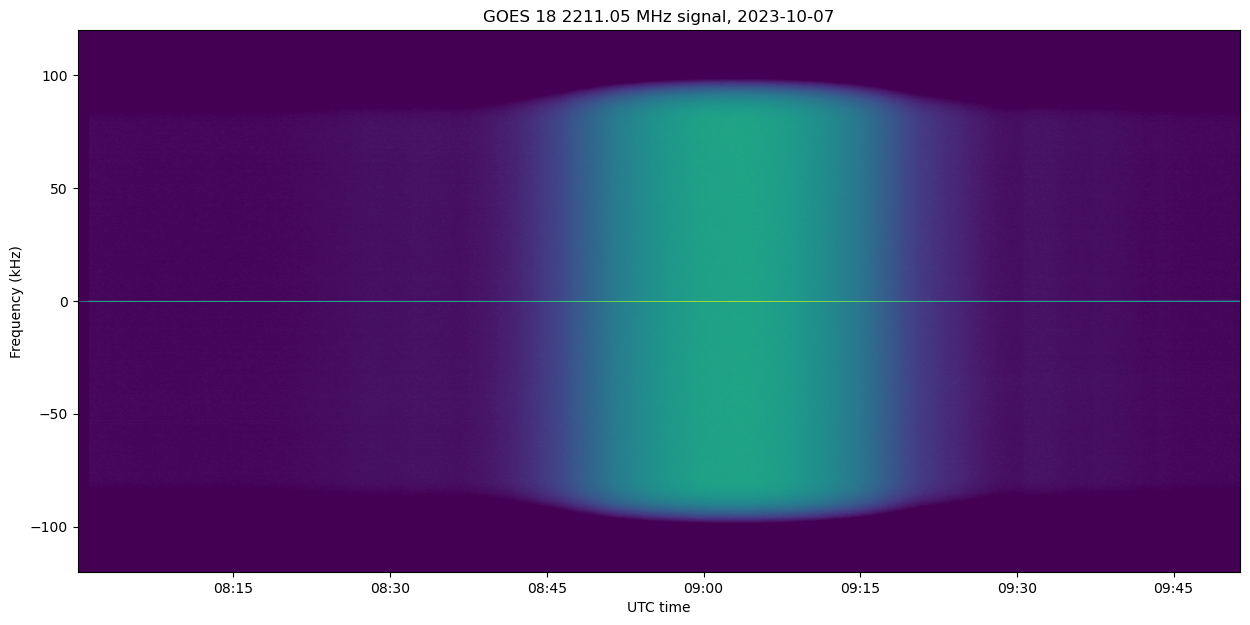

In [4]:
result = xx + yy

# Calculate the minimum and maximum values in the result
min_value = 10*np.log10(np.min(result))
max_value = 10*np.log10(np.max(result))

print("Minimum Value:", min_value)
print("Maximum Value:", max_value)



plt.figure(figsize = (15,15), facecolor = 'w')
plt.imshow(10*np.log10(xx+yy)[:,::-1].T, extent = (mdates.date2num(t[0]),mdates.date2num(t[-1]), -120, 120),
          aspect = 1.5e-4,  vmin = -25, vmax = -10 )
plt.gca().set_xlim((t[0], t[-1]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylabel('Frequency (kHz)')
plt.xlabel('UTC time')
plt.title('GOES 18 2211.05 MHz signal, 2023-10-07');
plt.savefig('signal_plot.png')

In [5]:
signal_peak = np.argmax(xx + yy, axis = 1)
offsets = np.arange(-2,3)
signal_xx = np.zeros(xx.shape[0])
signal_yy = np.zeros(yy.shape[0])
signal_xy = np.zeros(xy.shape[0], dtype = 'complex')
for offset in np.arange(-2,3):
    signal_xx += xx[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_yy += yy[np.arange(signal_peak.shape[0]), signal_peak + offset]
    signal_xy += xy[np.arange(signal_peak.shape[0]), signal_peak + offset]
signal_xx /= offsets.size
signal_yy /= offsets.size
signal_xy /= offsets.size
gain_xx_yy = np.median(signal_xx + signal_yy)
signal_xx /= gain_xx_yy
signal_yy /= gain_xx_yy
signal_xy /= gain_xx_yy

In [6]:
I = signal_xx + signal_yy
Q = signal_xx - signal_yy
U = 2*signal_xy.real
V = -2*signal_xy.imag
L = Q + 1j*U
P = np.sqrt(Q**2 + U**2 + V**2)

slice(6, None, None)


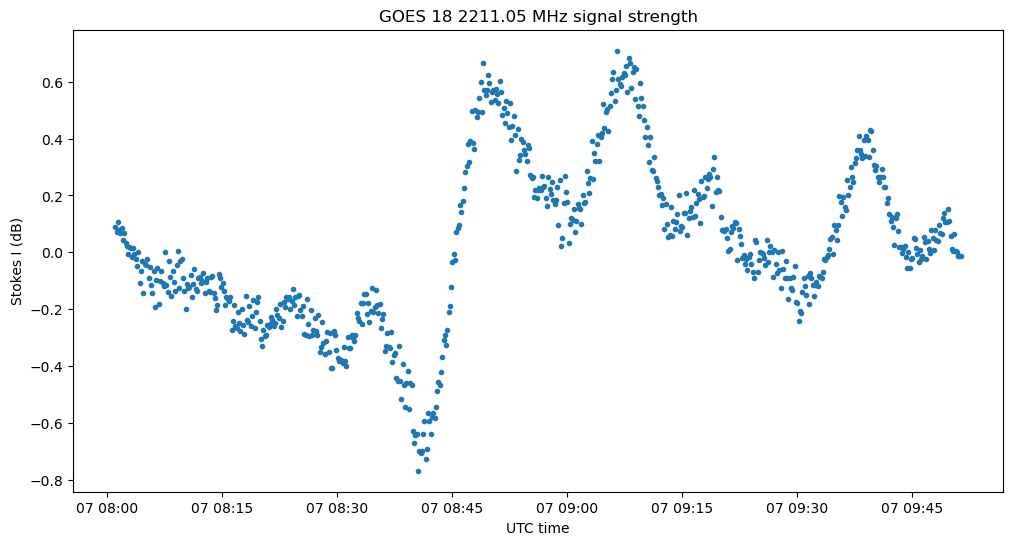

In [7]:
sel = slice(6,None)
print(sel)
plt.figure(figsize = (12, 6))
plt.plot(t[sel], 10*np.log10(I[sel]), '.')
plt.ylabel('Stokes I (dB)')
plt.xlabel('UTC time')
plt.title('GOES 18 2211.05 MHz signal strength');
plt.savefig('stokesI.png')

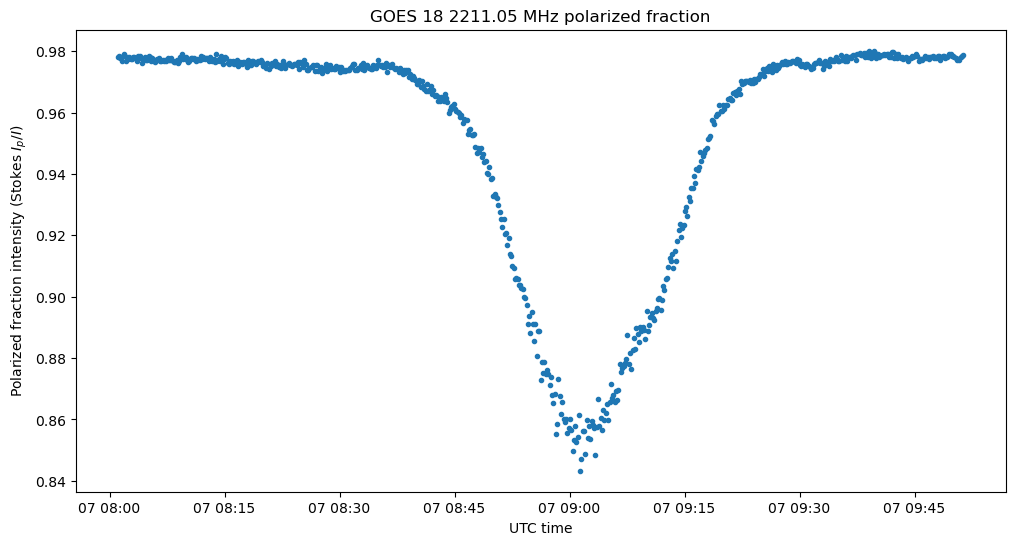

In [8]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (P/I)[sel], '.')
plt.xlabel('UTC time')
plt.ylabel('Polarized fraction intensity (Stokes $I_p/I$)')
plt.title('GOES 18 2211.05 MHz polarized fraction');
plt.savefig('StokesP_I.png')

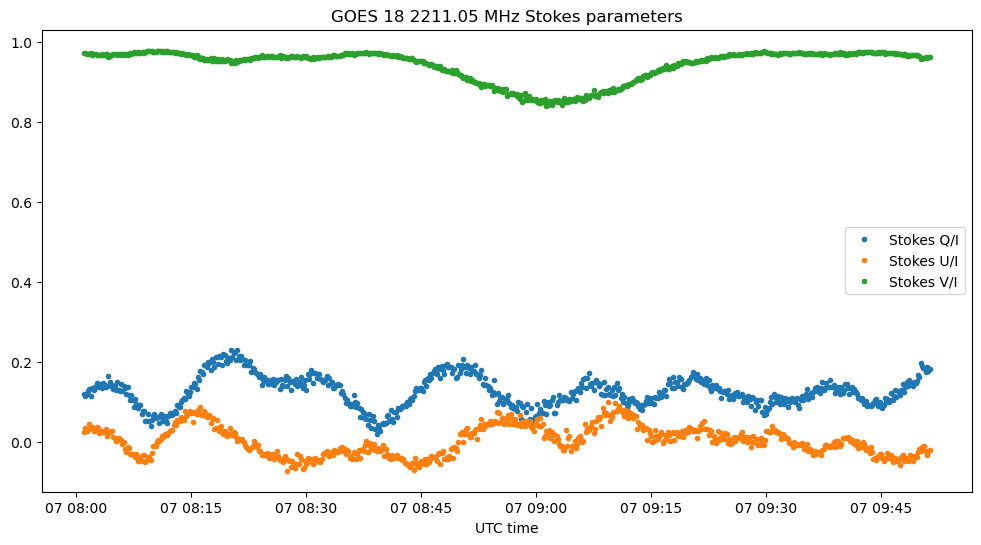

In [9]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (Q/I)[sel], '.')
plt.plot(t[sel], (U/I)[sel], '.')
plt.plot(t[sel], (V/I)[sel], '.')
plt.legend(['Stokes Q/I', 'Stokes U/I', 'Stokes V/I'])
plt.xlabel('UTC time')
plt.title('GOES 18 2211.05 MHz Stokes parameters');
plt.savefig('stokes_parameters.png')

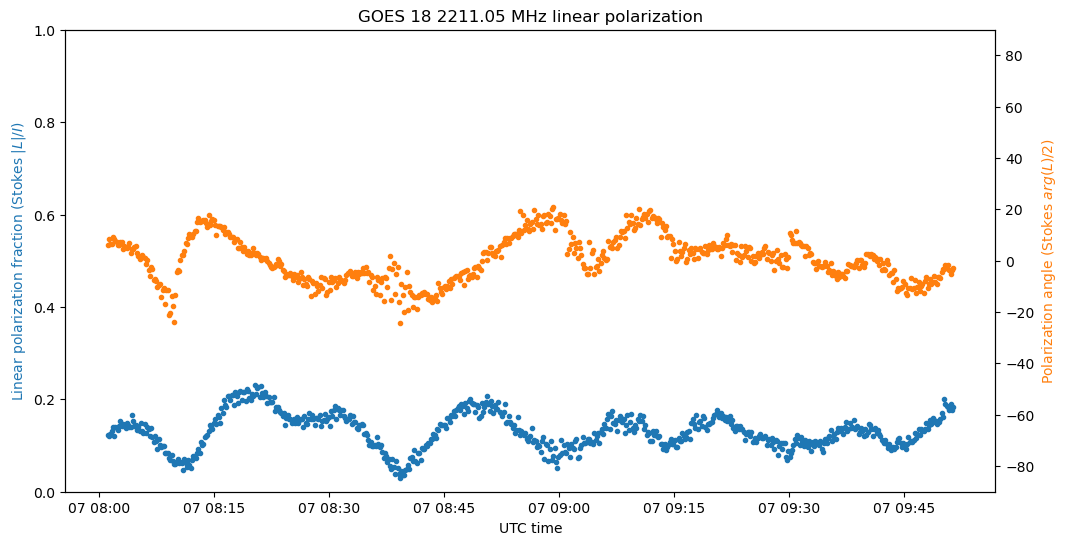

In [10]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (np.abs(L)/I)[sel], '.')
plt.ylim((0,1))
plt.xlabel('UTC time')
plt.ylabel('Linear polarization fraction (Stokes $|L|/I$)', color = 'C0')
ax2 = plt.gca().twinx()
plt.plot(t[sel], np.rad2deg(np.angle(L[sel])/2), '.', color = 'C1')
ax2.set_ylabel('Polarization angle (Stokes $arg(L)/2$)', color = 'C1')
ax2.set_ylim((-90,90))
plt.title('GOES 18 2211.05 MHz linear polarization');
plt.savefig('stokes_linear.png')

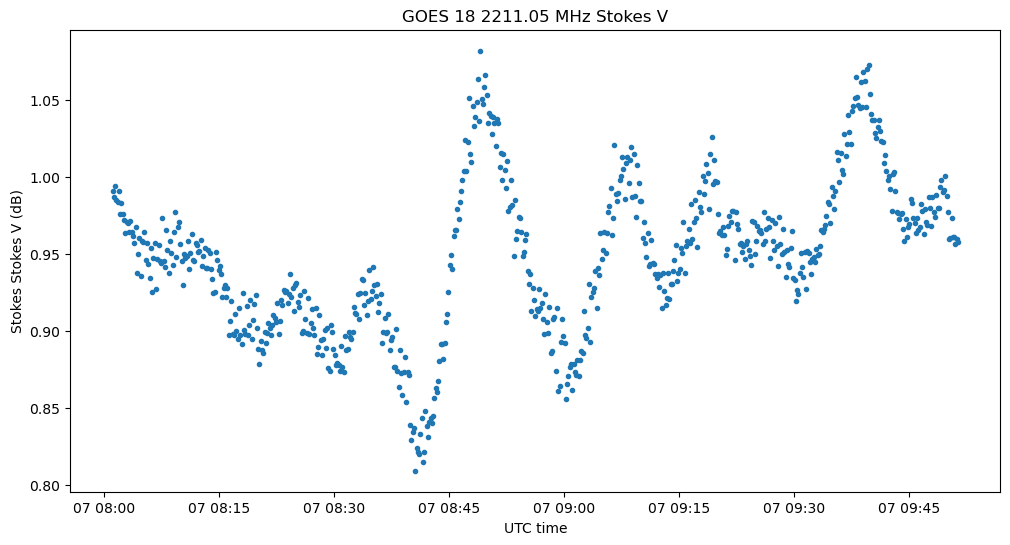

In [11]:
plt.figure(figsize = (12, 6))
plt.plot(t[sel], (V)[sel], '.')
plt.xlabel('UTC time')
plt.ylabel('Stokes Stokes V (dB)')
plt.title('GOES 18 2211.05 MHz Stokes V');
plt.savefig('stokesV.png')